The goal of this notebook is to find optimal combinations of parameters for minimum model error. 

In [20]:
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from scipy import stats
from scipy import interpolate
import math
import matplotlib.pyplot as plt
import pandas as pd # to read excel
print(f"pandas version is {pd.__version__}")
import seaborn as sns
from array import *
import researchpy as rp
import scipy.stats as stats
%matplotlib inline

from local_functions import *

import datetime

pandas version is 1.3.4


In [21]:
# Functions for optimization (i.e producing random parametric combination)
import SALib
from SALib.sample import saltelli
from SALib.analyze import sobol
from sklearn.linear_model import LinearRegression

In [22]:
# 1. Indoor system
#   a. Read data and parameters from excel file

xl = pd.ExcelFile('../data/Parameters.xlsx')
x2 = pd.ExcelFile('../data/Data.xlsx')

# Import parameters into df1
df1 = xl.parse('Parameters')

# assigmment of parameters to values: 
for key,val in zip(df1.Parameter,df1.Indoor_value):
    exec(key + '=val')
    print(key,val)

# Import indoor data into df2
df2 = x2.parse('Indoor')

df2.head()

umol_to_percent_DW 0.0014
n_days 7.0
Duration 7.0
Nint0 1.85
m0 0.15
Nintcrit 4.5
miu 0.04
Nintmax 5.5
Nintmin 0.48
Ks 14.0
Vmax 60.0
Z 0.178
KI 35.0
K0 0.5
Ka 0.05
Topt 18.0
Tmin 5.0
Tmax 35.0
n 5.0
losses20 0.0016
teta 1.047
Sopt 25.0
Smin 3.0
Smax 48.0
Shigh 30.0
Slow 12.0
KN 1.1
dNextoutdt 0.014
dNextindt 0.0
dmoutdt 0.0
Next00  4032.0
dilution 0.0


,Sample,Exp,Sleeve,Week,Stage,Timei,Timeh,Time,DW,mmi,...,Frequency,Amplitude,Duration,Flux,Sporulated,Comment,Day,Comment2,Unnamed: 38,N_Saturation
0,0.0,1,0,0.0,i,"2019,3,12,13,0","2019,3,12,13,0","2019,3,12,13,0",0.750,NaN,...,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,yes
1,0.7,1,0,0.0,f,"2019,3,12,13,0","2019,3,12,13,0","2019,3,19,13,0",0.753,50.0,...,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,yes
2,1.0,1,1,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.144,NaN,...,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes
3,2.0,1,2,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.153,NaN,...,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes
4,3.0,1,3,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.159,NaN,...,1.0,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes


In [23]:
# b. process data (indoor measurements)

    # 1. Convert Time into hours
T = []
for i in df2['Sample'][:]:
    T1 = df2['Timei'][df2['Sample'].values.tolist().index(i)]
    T2 = df2['Time'][df2['Sample'].values.tolist().index(i)]
    T.append(Time_to_Hours(T1,T2))
df2['T'] = T

    # 2. Make a temp DF (df2_temp) by filtering the original df - remove 'wierd' results (i.e sporulation) 

df2_Reduced = df2[(df2.Treatment != 'Acclimation') & (df2.Week <= 3) & (df2.Stage != 'i') & (df2.Sporulated == 'No')&(df2.Comment != 'Exclude')]
df2_Reduced

,Sample,Exp,Sleeve,Week,Stage,Timei,Timeh,Time,DW,mmi,...,Amplitude,Duration,Flux,Sporulated,Comment,Day,Comment2,Unnamed: 38,N_Saturation,T
11,1.7,1,1,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.408,4.8,...,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,165
12,2.7,1,2,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.426,5.1,...,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,165
13,3.7,1,3,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.330,5.3,...,1000.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,165
14,4.7,1,4,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.267,5.2,...,2000.0,4.0,2000.0,No,NaN,NaN,NaN,NaN,no,165
15,5.7,1,5,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.267,4.8,...,2000.0,4.0,2000.0,No,NaN,NaN,NaN,NaN,no,165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,144.7,5,4,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.426,5.0,...,500.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,501
468,145.7,5,5,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.321,5.0,...,500.0,168.0,1500.0,No,NaN,NaN,NaN,NaN,yes,501
469,146.7,5,6,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.297,5.0,...,500.0,168.0,1500.0,No,NaN,NaN,NaN,NaN,yes,501
470,147.7,5,7,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.357,5.0,...,200.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,501


In [24]:
df2_ReducedTemp = df2_Reduced[(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)]
df2_ReducedTemp

,Sample,Exp,Sleeve,Week,Stage,Timei,Timeh,Time,DW,mmi,...,Amplitude,Duration,Flux,Sporulated,Comment,Day,Comment2,Unnamed: 38,N_Saturation,T
122,61.1,3,1,1.0,NaN,"2019,7,22,13,0","2019,7,22,13,0","2019,7,23,14,0",0.165,NaN,...,500.0,168.0,1000.0,No,Minor treaming (0.2g),NaN,NaN,NaN,yes,25
123,61.2,3,1,1.0,NaN,"2019,7,22,13,0","2019,7,22,13,0","2019,7,24,9,0",0.180,NaN,...,500.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,44
124,61.3,3,1,1.0,NaN,"2019,7,22,13,0","2019,7,22,13,0","2019,7,25,10,0",0.225,NaN,...,500.0,168.0,1000.0,No,NaN,NaN,Check Next,NaN,yes,69
125,61.6,3,1,1.0,NaN,"2019,7,22,13,0","2019,7,22,13,0","2019,7,28,9,0",0.360,NaN,...,500.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,140
127,62.2,3,2,1.0,NaN,"2019,7,22,13,0","2019,7,22,13,0","2019,7,24,9,0",0.204,NaN,...,500.0,168.0,1000.0,No,Minor treaming (0.2g),NaN,NaN,NaN,yes,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,115.7,4,5,3.0,f,"2019,10,3,11,0","2019,10,17,10,0","2019,10,24,12,0",0.447,5.0,...,500.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,505
368,116.7,4,6,3.0,f,"2019,10,3,11,0","2019,10,17,10,0","2019,10,24,12,0",0.423,5.0,...,500.0,168.0,1000.0,No,NaN,NaN,NaN,NaN,yes,505
369,117.7,4,7,3.0,f,"2019,10,3,11,0","2019,10,17,10,0","2019,10,24,12,0",0.414,5.0,...,500.0,168.0,1500.0,No,NaN,NaN,NaN,NaN,yes,505
370,118.7,4,8,3.0,f,"2019,10,3,11,0","2019,10,17,10,0","2019,10,24,12,0",0.411,5.0,...,500.0,168.0,1500.0,No,NaN,NaN,NaN,NaN,yes,505


In [25]:
# 4. Calculate model results for:
#   a. Indoor system
    # I. Produce an array ("m/Nint/Next_mod_all") of all model results (hours 1-504) for each treatment

In [26]:
# optimized parameters: bounds
#'µmax'
problem = {
    'num_vars': 9,
    'names': ['λ20','Nintmax','Nintcrit','Nextlosses','Ks','Vmax','KI','K0','Ka'],
    'bounds': [[0.001,0.005],
               [4.5,5],
               [0.7,3.2],
               [0.001,0.02],
               [10,30],
               [50,250],
               [15, 150],
               [0.1,3],
               [0.01,0.2]]
}

print(problem)

{'num_vars': 9, 'names': ['λ20', 'Nintmax', 'Nintcrit', 'Nextlosses', 'Ks', 'Vmax', 'KI', 'K0', 'Ka'], 'bounds': [[0.001, 0.005], [4.5, 5], [0.7, 3.2], [0.001, 0.02], [10, 30], [50, 250], [15, 150], [0.1, 3], [0.01, 0.2]]}


In [27]:
problem['bounds']

[[0.001, 0.005],
 [4.5, 5],
 [0.7, 3.2],
 [0.001, 0.02],
 [10, 30],
 [50, 250],
 [15, 150],
 [0.1, 3],
 [0.01, 0.2]]

In [28]:
from scipy.optimize import Bounds
tmp = np.array(problem['bounds']).T.squeeze().tolist()
bounds = Bounds(tmp[0],tmp[1])

In [29]:
# model simulations with different parameteric combinations


Temp = 22
S = 39 # fix salinity function and S=40

Treatments = ['1000/1/168','500/2/168','500/3/168','2000/1/168','200/5/168']
Nint0All = ['2.12','2.13','2.32','2.05','1.3']

# r = 0

miu = 0.03
# for p, X in enumerate(param_values):

def residual(X):
    """ estimates the residual as total RMS for the given set of parameters X """
   
    #miu = X[0]
    lossess20 = X[0]
    Nintmax = X[1]
    Nintcrit = X[2]
    dNextoutdt = X[3]
    Ks = X[4]
    Vmax = X[5]
    KI = X[6]
    K0 = X[7]
    Ka = X[8]


    
    TModAll = [] # Each sub-array has the time steps of a specific treatment (periods)
    mExpAllTimes,NintExpAllTimes,NextExpAllTimes = [],[],[]
    mModAll,NintModAll,NextModAll = [],[],[]

    for i in Treatments:
        
        df2Temp = df2_ReducedTemp[(df2_ReducedTemp.Treatment == i)]
        #mTemp = df2Temp[(np.isnan(df2Temp.DW) != True)]['DW']
        #mTimeTemp = df2Temp[(np.isnan(df2Temp.DW) != True)]['T']
        #NintTemp = df2Temp[(np.isnan(df2Temp.N) != True)]['N']
        #NintTimeTemp = df2Temp[(np.isnan(df2Temp.N) != True)]['T']
        #NextTemp = df2Temp[(np.isnan(df2Temp.NH4) != True)]['NH4']
        #NextTimeTemp = df2Temp[(np.isnan(df2Temp.NH4) != True)]['T']
        mTemp = df2Temp[(~np.isnan(df2Temp.DW))]['DW']
        mTimeTemp = df2Temp[(~np.isnan(df2Temp.DW))]['T']
        NintTemp = df2Temp[(~np.isnan(df2Temp.N))]['N']
        NintTimeTemp = df2Temp[(~np.isnan(df2Temp.N))]['T']
        NextTemp = df2Temp[(~np.isnan(df2Temp.NH4))]['NH4']
        NextTimeTemp = df2Temp[(~np.isnan(df2Temp.NH4))]['T']

        Tr = []
        Tr = i.split('/')
        Tr = [float(i) for i in Tr]
        Amplitude = Tr[0]
        Period = float(7/Tr[1]) # Period is in hours
        Duration = Tr[2]/24

        NEXT, NINT, M, TT = [],[],[],[]

        n_days = Duration*3
        count_periods = 0

        # hour = 0 is 1pm
        # in the indoor settings we have to solve for shorter periods, 
        # at the beginning of the Treatment we reset Nint, Next, m
        # at the beginning of each Period we set Next to the last Amplitude, 
        # m0 to the end of previous solution of ode()

        # Let's prepare the IO(t) function that will be supplied to odeint 
        # instead of a scalar. 

        all_treatment_hours = np.arange(0,n_days*24,dtype=int)

        # 8pm on the first day is zero crossing of this one 8pm - 10m = 7 hours
        offtimes = all_treatment_hours[np.mod(all_treatment_hours - 7,24) == 0]
        offtimes = np.r_[offtimes,all_treatment_hours[-1]+1] # last hour would be whatever

        # 6am on the next day is zero crossing of this one, 6am - 8pm is 10 hours
        ontimes = all_treatment_hours[np.mod(all_treatment_hours - 7 + 10,24) == 0]
        # and the iniital hour as we always start at 1pm, during ontime
        ontimes = np.r_[int(0),ontimes]

        # prepare the duty cycle
        I0set = np.zeros_like(all_treatment_hours)
        for s,e in zip(ontimes,offtimes):
            I0set[s:e] = 80

        # if you want to replace it by a "constant" I0 then replace the lines above with
        # the following line and then it will also give you a constant solution you had before

        # I0set = np.ones_like(all_treatment_hours)*80


        I0 = interpolate.interp1d(all_treatment_hours, I0set, bounds_error=False, fill_value="extrapolate")

        for hour in np.arange(0,n_days*24,round(Period*24,0)):
            if hour == 0:
                Nint_0 = Nint0All[Treatments.index(i)]
                m_0 = m0
                Next_0 = Amplitude

            if hour > 0 and np.mod(hour,round(Period*24,0)) == 0:
                count_periods = count_periods + 1

                if count_periods == Tr[1]:
                    # reset everything, except Nint
                    Nint_0 = NINT[-1][-1]
                    Next_0 = Amplitude
                    m_0 = m0
                    count_periods = 0
                else:
                    # period passed, not Duration
                    # add amplitude, keep going 
                    Next_0 = NEXT[-1][-1] + Amplitude
                    Nint_0 = NINT[-1][-1]
                    m_0 = M[-1][-1]


            # Here we want to send odeint the times of the light sub-period or 
            # darkness sub-period

            x0 = [Next_0,Nint_0,m_0]
            # t = np.linspace(hour,hour+Period*24) # every time we solve ODE for 24 hours * Period
            t = np.arange(hour, hour+Period*24) # can also ask for report on round hours

            x = odeint(controlled_N_constST,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Z,KI,K0,Ka,
                                                   losses20,teta,umol_to_percent_DW,I0,Temp),printmessg=0,hmax=.1)

            NEXT.append(x[: , 0])
            NINT.append(x[: , 1])
            M.append(x[: , 2])
            TT.append(t)

            t_model = np.hstack(TT)
            Next_model = np.hstack(NEXT)
            Nint_model = np.hstack(NINT)
            m_model = np.hstack(M)

        TModAll.append(TT)
        mExpAllTimes.append(mTimeTemp)
        NintExpAllTimes.append(NintTimeTemp)
        NextExpAllTimes.append(NextTimeTemp)

        mModAll.append(m_model)
        NintModAll.append(Nint_model)
        NextModAll.append(Next_model)
        
    # Adjusts measurment time to model durations - so that maximum biomass measurements are compared to maximum biomass
    # predictions and not to the initial stocking density (m0)

    TModTemp = []
    TModAllOrg = []
    mModReducedAll, NintModReducedAll, NextModReducedAll = [],[],[]
    for j in range(len(TModAll)): # loops over 5 treatments
        #print(j)
        for k in range(len(TModAll[j])): # Loops over periods in each treatment
            Ttemp = TModAll[j][k]
            for l in Ttemp: #The model ends at 504 hours, but some measurement reach also 50 hours. This sets a 504 hour limit
                if l > 504:
                    l = 504
                TModTemp.append(l)
        TModAllOrg.append(TModTemp)
        TModTemp = []

    for j in range(len(TModAll)):
        gm = interpolate.interp1d(TModAllOrg[j], mModAll[j],kind = 'linear')
        mModReduced = []
        for k in mExpAllTimes[j]:
            #print(mExpAllTimes[i])
            if k >= 168 and k < 180:
                k = 167.9
            elif k >= 336 and k < 345:
                k = 335.9
            elif k > 504:
                k = 504
            #print(j)
            mModReduced.append(gm(k-1))

        mModReducedAll.append(mModReduced)
        gNint = interpolate.interp1d(TModAllOrg[j], NintModAll[j],kind = 'linear')
        NintModReduced = []
        for k in NintExpAllTimes[j]:
            if k >= 168 and k < 180:
                k = 167.9
            if k >= 336 and k < 345:
                k = 335.9
            if k > 504:
                k = 504
            NintModReduced.append(gNint(k-1))
        NintModReducedAll.append(NintModReduced)
        gNext = interpolate.interp1d(TModAllOrg[j], NextModAll[j],kind = 'linear')    
        NextModReduced = []
        for k in NextExpAllTimes[j]:
            if k >= 168 and k < 180:
                k = 167.9
            if k >= 336 and k < 345:
                k = 335.9
            if k > 504:
                k = 504
            NextModReduced.append(gNext(k-1))
        NextModReducedAll.append(NextModReduced)

    
    # calculate errors
    mSRE_All,NintSRE_All,NextSRE_All = [],[],[]
    for j in range(len(Treatments)):
        mSRE,NintSRE,NextSRE = [],[],[]
        RMSREmAll,RMSRENintAll = [],[]
        
        # df2m = df2_ReducedTemp[(np.isnan(df2_ReducedTemp.DW) != True)&(df2_ReducedTemp.Treatment == Treatments[j])]
        tmp = df2_ReducedTemp[~np.isnan(df2_ReducedTemp.DW)]
        df2m = tmp.loc[tmp.Treatment == Treatments[j]]

        #print('Treatment: ' + str(Treatments[j]) + '\n\nm\n')
        #print('Number of samples: ' + str(len(df2m.Sample)) + '\n')
        l = 0
        for k in df2m.Sample:
            mexp = df2m.DW
            #print(j)
            #print(len(mModReducedAll))
            mmod = mModReducedAll[j]
            mSRE.append(((mexp.iloc[l]-mmod[l])/mmod[l])**2)
            mSRE_All.append(((mexp.iloc[l]-mmod[l])/mmod[l])**2)
            #print('Sample #' + str(math.floor(float(k))))
            #print('Measured biomass: ' + str(round(mexp.iloc[l],3)))
            #print('Modeled biomass: ' + str(round(float(mmod[l]),3)) + '\n')
            l = l + 1
            RMSREm = round((np.mean(mSRE))**0.5,3)
            
        #print('The RMSRE of m in treamtment ' + str(Treatments[j]) + ' is: ' + str(RMSREm) + '\n')


        # df2Nint = df2_ReducedTemp[(np.isnan(df2_ReducedTemp.N) != True)][(df2_ReducedTemp.Treatment == Treatments[j])]
        tmp = df2_ReducedTemp[~np.isnan(df2_ReducedTemp.N)]
        df2Nint = tmp.loc[tmp.Treatment == Treatments[j]]
        #print('\nNint\n')
        #print('Number of samples: ' + str(len(df2Nint.Sample)) + '\n')
        l = 0
        for k in df2Nint.Sample:
            Nintexp = df2Nint.N
            Nintmod = NintModReducedAll[j]
            NintSRE.append(((Nintexp.iloc[l]-Nintmod[l])/Nintmod[l])**2)
            NintSRE_All.append(((Nintexp.iloc[l]-Nintmod[l])/Nintmod[l])**2)
            #print('Sample #' + str(math.floor(float(k))))
            #print('Measured Nint: ' + str(round(float(Nintexp.iloc[l]),3)))     
            #print('Modeled Nint: ' + str(round(float(Nintmod[l]),3)) + '\n')        
            l = l + 1
            RMSRENint = round((np.mean(NintSRE))**0.5,3)
            
        #print('\nThe RMSRE of Nint in treamtment ' + str(Treatments[j]) + ' is: ' + str(RMSRENint) + '\n')

        # df2Next = df2_ReducedTemp[(np.isnan(df2_ReducedTemp.NH4) != True)][(df2_ReducedTemp.Treatment == Treatments[j])]
        tmp = df2_ReducedTemp[~np.isnan(df2_ReducedTemp.NH4)]
        df2Next = tmp.loc[tmp.Treatment == Treatments[j]]        
        #print('\nNext\n')
        #print('Number of samples: ' + str(len(df2Next.Sample)) + '\n')
        l = 0
        for k in df2Next.Sample:
            Nextexp = df2Next.NH4
            if Nextexp.iloc[l] < 0:
                Nextexp.iloc[l] = 0
            Nextmod = NextModReducedAll[j]
            NextSRE.append(((Nextexp.iloc[l]-Nextmod[l])/Nextmod[l])**2)
            #print('Sample #' + str(math.floor(float(k))))
            #print('Measured Next: ' + str(round(float(Nextexp.iloc[l]),3)))     
            #print('Modeled Next: ' + str(round(float(Nextmod[l]),3)) + '\n')        
            l = l + 1
            RMSRENext = round((np.mean(NextSRE))**0.5,3)
            NextSRE_All.append(NextSRE)
        #print('\nThe RMSRE of Next in treamtment ' + str(Treatments[j]) + ' is: ' + str(RMSRENext) + '\n')
    #print('End of treatment ' + str(Treatments[j]) + '\n')
    

    #mSRE_AllTemp = []
    #for i in range(len(mSRE_All)):
    #    for j in range(len(mSRE_All[i])):
    #        mSRE_AllTemp.append(mSRE_All[i][j])
    RMSREm = round((np.mean(mSRE_All))**0.5,3)

    #NintSRE_AllTemp = []
    #for i in range(len(NintSRE_All)):
    #    for j in range(len(NintSRE_All[i])):
    #        NintSRE_AllTemp.append(NintSRE_All[i][j])
    RMSRENint = round((np.mean(NintSRE_All))**0.5,3)

    return RMSREm + RMSRENint
    
    # evaluate_model1.append(RMSREm)
    # evaluate_model2.append(RMSRENint)
    # #evaluate_model3.append(RMSRENext)

    # Y1[p] = round(evaluate_model1[-1],3)
    # Y2[p] = round(evaluate_model2[-1],3)
    # print(r)
    # r = r+1

In [30]:
from scipy.optimize import minimize

param_values = np.array(problem['bounds']).T.squeeze()
param_values[0,:]


sol = minimize(residual,param_values[0,:],bounds=bounds,method='SLSQP')

C:\Users\alex\miniconda3\envs\meiron\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [31]:
print(sol)

     fun: 0.618
     jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 10
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([1.0e-03, 4.5e+00, 7.0e-01, 1.0e-03, 1.0e+01, 5.0e+01, 1.5e+01,
       1.0e-01, 1.0e-02])


In [32]:
X = sol.x

In [33]:
#miu = X[0]
miu = 0.03
lossess20 = X[0]
Nintmax = X[1]
Nintcrit = X[2]
dNextoutdt = X[3]
Ks = X[4]
Vmax = X[5]
KI = X[6]
K0 = X[7]
Ka = X[8]


Treatment: 1000/1/168
Number of samples:
m: 27 Nint: 19 Next: 26
7.0
0.0
Starting point
168.0
Duration
336.0
Duration

Treatment: 500/2/168
Number of samples:
m: 66 Nint: 38 Next: 90
3.5
0.0
Starting point
84.0
Period
168.0
Duration
252.0
Period
336.0
Duration
420.0
Period

Treatment: 500/3/168
Number of samples:
m: 18 Nint: 12 Next: 18
2.3333333333333335
0.0
Starting point
56.0
Period
112.0
Period
168.0
Duration
224.0
Period
280.0
Period
336.0
Duration
392.0
Period
448.0
Period

Treatment: 2000/1/168
Number of samples:
m: 0 Nint: 0 Next: 0
7.0
0.0
Starting point
168.0
Duration
336.0
Duration

Treatment: 200/5/168
Number of samples:
m: 0 Nint: 0 Next: 0
1.4
0.0
Starting point
34.0
Period
68.0
Period
102.0
Period
136.0
Period
170.0
Duration
204.0
Period
238.0
Period
272.0
Period
306.0
Period
340.0
Duration
374.0
Period
408.0
Period
442.0
Period
476.0
Period


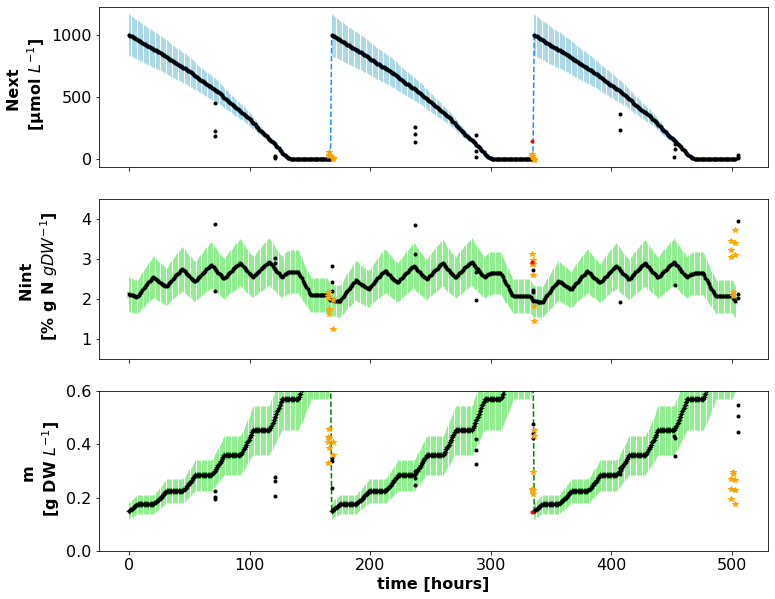

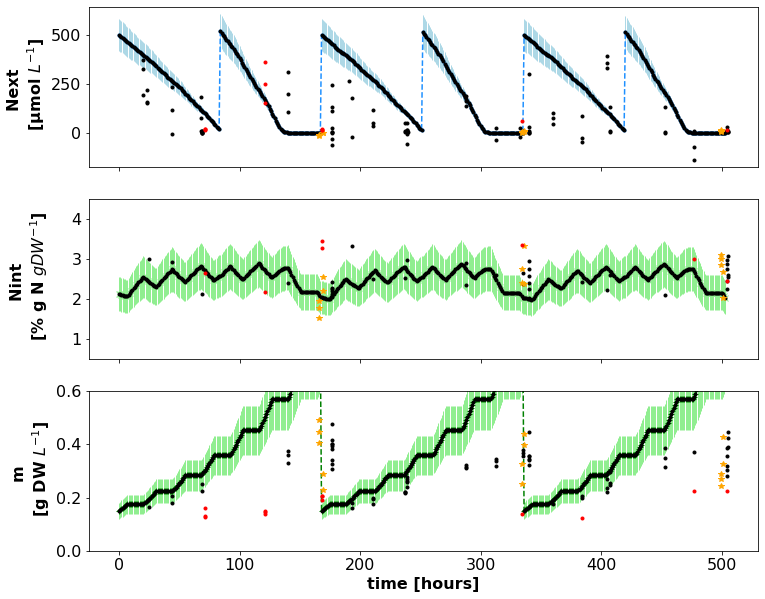

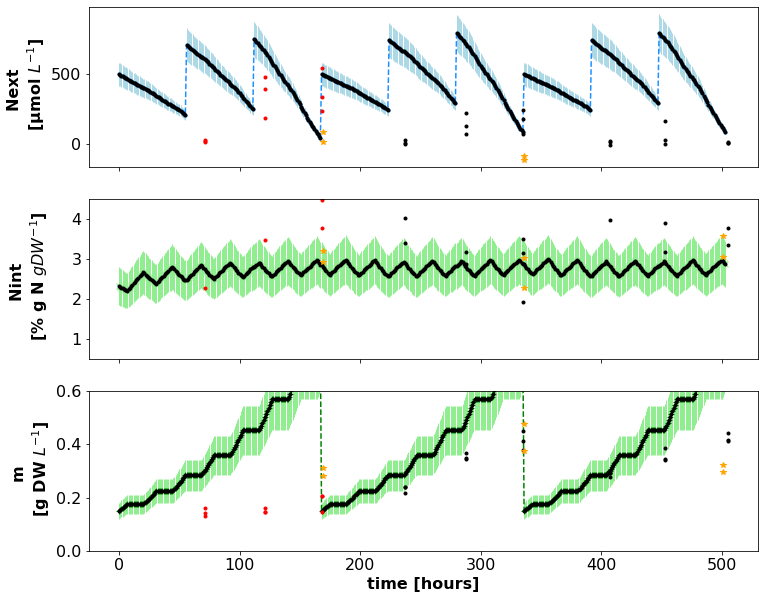

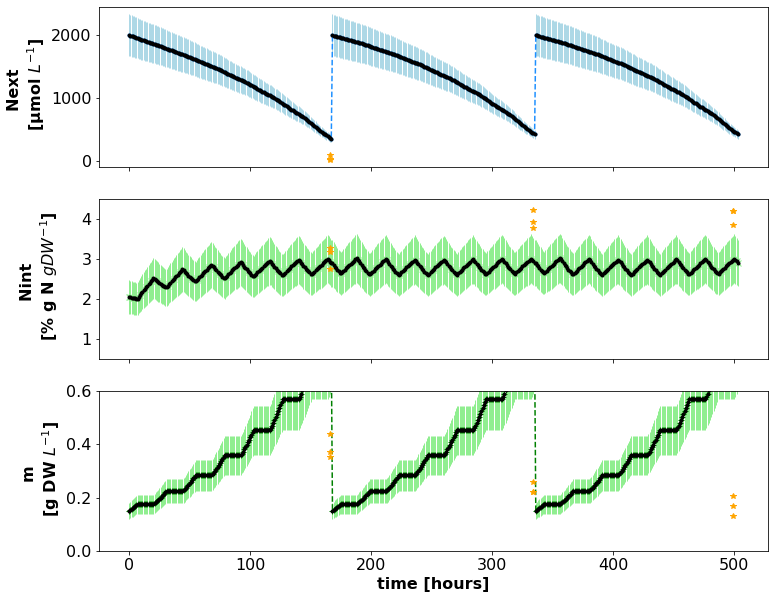

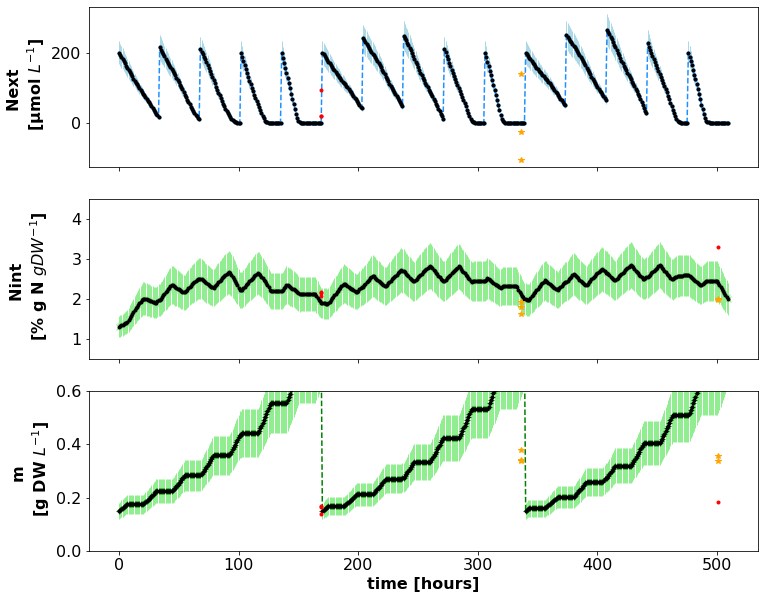

In [34]:
#n = 2
# Visual calibration of high resolution data (data from sporulation events was excluded)

# Calibration data - experiments #3 and #4 (black)
# Validation data - experiments #1, #2 and #5 (orange)
#Ka = 0.15

TModAll = [] # Each sub-array has the time steps of a specific treatment (periods)
mExpAllTimes_cal,NintExpAllTimes_cal,NextExpAllTimes_cal = [],[],[]
mModAll,NintModAll,NextModAll = [],[],[]
mExpAllTimes_val,NintExpAllTimes_val,NextExpAllTimes_val = [],[],[]
mModAll_val,NintModAll_val,NextModAll_val = [],[],[]
mExpAllTimes_spor,NintExpAllTimes_spor,NextExpAllTimes_spor = [],[],[]
mModAll_spor,NintModAll_spor,NextModAll_spor = [],[],[]

mTimeTemp_spor = 0

Treatments = ['1000/1/168','500/2/168','500/3/168','2000/1/168','200/5/168']
Nint0All = ['2.12','2.13','2.32','2.05','1.3']

Temp = 22
#I0 = 80
S = 39 # fix salinity function and S=40

df2_Reduced = df2[(df2.Treatment != 'Acclimation') & (df2.Week <= 3) & (df2.Stage != 'i') & (df2.Sporulated == 'No')&(df2.Comment != 'Exclude')]
df2_cal = df2_Reduced[(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)]
df2_val = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)&(df2_Reduced.Exp != 3)&(df2_Reduced.Exp != 4)]
df2_spor = df2[(np.isnan(df2.DW) != True)&(df2.Treatment != 'Acclimation')&(df2.Duration == 168) & (df2.Week <= 3) & (df2.Stage != 'i') & (df2.Sporulated == 'Yes')&(df2.Comment != 'Exclude')]


for i in Treatments:
    print('\nTreatment: ' + str(i))
    # calibration data
    df2Temp_cal = df2_cal[(df2_cal.Treatment == i)]
    mTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.DW) != True)]['DW']
    mTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.DW) != True)]['T']
    NintTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.N) != True)]['N']
    NintTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.N) != True)]['T']
    NextTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.NH4) != True)]['NH4']
    NextTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.NH4) != True)]['T']
    
    # validation data
    df2Temp_val = df2_val[(df2_val.Treatment == i)]
    mTemp_val = df2Temp_val[(np.isnan(df2Temp_val.DW) != True)]['DW']
    mTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.DW) != True)]['T']
    NintTemp_val = df2Temp_val[(np.isnan(df2Temp_val.N) != True)]['N']
    NintTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.N) != True)]['T']
    NextTemp_val = df2Temp_val[(np.isnan(df2Temp_val.NH4) != True)]['NH4']
    NextTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.NH4) != True)]['T']
    mTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.DW))]['DW']
    mTimeTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.DW))]['T']
    NintTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.N))]['N']
    NintTimeTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.N))]['T']
    NextTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.NH4))]['NH4']
    NextTimeTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.NH4))]['T']
    
    # sporulation data
    del mTimeTemp_spor
    df2Temp_spor = df2_spor[(df2_spor.Treatment == i)]
    mTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.DW) != True)]['DW']
    mTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.DW) != True)]['T']
    NintTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.N) != True)]['N']
    NintTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.N) != True)]['T']
    NextTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.NH4) != True)]['NH4']
    NextTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.NH4) != True)]['T']
    mTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.DW))]['DW']
    mTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.DW))]['T']
    NintTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.N))]['N']
    NintTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.N))]['T']
    NextTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.NH4))]['NH4']
    NextTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.NH4))]['T']
    
    print('Number of samples:\nm: ' + str(len(mTimeTemp_cal)) + ' Nint: ' + str(len(NintTimeTemp_cal)) + ' Next: ' + str(len(NextTimeTemp_cal)))
    
    # Amplitude / Period / Duration parameters from input
    Tr = []
    Tr = i.split('/')
    Tr = [float(i) for i in Tr]
    Amplitude = Tr[0]
    Period = float(7/Tr[1]) # Period is in hours
    print(Period)
    Duration = Tr[2]/24
    
    NEXT, NINT, M, TT = [],[],[],[]

    n_days = Duration*3
    count_periods = 0
    
    #T1 = '2019,02,14,17,0'
    #T2 = df3Temp['Timei']
    #T2 = T2.tolist()[0]
    #t0 = Time_to_Hours(T1,T2)
    
    # hour = 0 is 1pm (Meiron)
    # in the indoor settings we have to solve for shorter periods, 
    # at the beginning of the Treatment we reset Nint, Next, m
    # at the beginning of each Period we set Next to the last Amplitude, 
    # m0 to the end of previous solution of ode()
    # 
    
    # Let's prepare the IO(t) function that will be supplied to odeint 
    # instead of a scalar. 
    
    all_treatment_hours = np.arange(0,n_days*24,dtype=int)
    
    # 8pm on the first day is zero crossing of this one 8pm - 10m = 7 hours
    offtimes = all_treatment_hours[np.mod(all_treatment_hours - 7,24) == 0]
    offtimes = np.r_[offtimes,all_treatment_hours[-1]+1] # last hour would be whatever
    
    # 6am on the next day is zero crossing of this one, 6am - 8pm is 10 hours
    ontimes = all_treatment_hours[np.mod(all_treatment_hours - 7 + 10,24) == 0]
    # and the iniital hour as we always start at 1pm, during ontime
    ontimes = np.r_[int(0),ontimes]
    
    # prepare the duty cycle
    I0set = np.zeros_like(all_treatment_hours)
    for s,e in zip(ontimes,offtimes):
        I0set[s:e] = 80
        
    # if you want to replace it by a "constant" I0 then replace the lines above with
    # the following line and then it will also give you a constant solution you had before
    
    # I0set = np.ones_like(all_treatment_hours)*80

    
    I0 = interpolate.interp1d(all_treatment_hours, I0set, bounds_error=False, fill_value="extrapolate")
    
    for hour in np.arange(0,n_days*24,round(Period*24,0)):
        print(hour)
        if hour == 0:
            print('Starting point')
            Nint_0 = Nint0All[Treatments.index(i)]
            m_0 = m0
            Next_0 = Amplitude
        
        if hour > 0 and np.mod(hour,round(Period*24,0)) == 0:
            count_periods = count_periods + 1
            
            if count_periods == Tr[1]:
                print('Duration')
                # reset everything, except Nint
                Nint_0 = NINT[-1][-1]
                Next_0 = Amplitude
                m_0 = m0
                count_periods = 0
            else:
                # period passed, not Duration
                # add amplitude, keep going 
                print('Period')
                Next_0 = NEXT[-1][-1] + Amplitude
                Nint_0 = NINT[-1][-1]
                m_0 = M[-1][-1]
   
                
        # Here we want to send odeint the times of the light sub-period or 
        # darkness sub-period

        x0 = [Next_0,Nint_0,m_0]
        # t = np.linspace(hour,hour+Period*24) # every time we solve ODE for 24 hours * Period
        t = np.arange(hour, hour+Period*24) # can also ask for report on round hours

        x = odeint(controlled_N_constST,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Z,KI,K0,Ka,
                losses20,teta,umol_to_percent_DW,I0,Temp),printmessg=0,hmax=.1)

        NEXT.append(x[: , 0])
        NINT.append(x[: , 1])
        M.append(x[: , 2])
        TT.append(t)
        
        t_model = np.hstack(TT)
        Next_model = np.hstack(NEXT)
        Nint_model = np.hstack(NINT)
        m_model = np.hstack(M)

    TModAll.append(TT)
    #Calibration experimental data
    mExpAllTimes_cal.append(mTimeTemp_cal)
    NintExpAllTimes_cal.append(NintTimeTemp_cal)
    NextExpAllTimes_cal.append(NextTimeTemp_cal)
    
    #model data
    mModAll.append(m_model)
    NintModAll.append(Nint_model)
    NextModAll.append(Next_model)
    
    #Valiaation experimental data
    mExpAllTimes_val.append(mTimeTemp_val)
    NintExpAllTimes_val.append(NintTimeTemp_val)
    NextExpAllTimes_val.append(NextTimeTemp_val)
    
    #Sporulation experimental data
    if len(mTimeTemp_spor) > 0: #np.empty(mTimeTemp_spor) != True:
        mExpAllTimes_spor.append(mTimeTemp_spor)
        NintExpAllTimes_spor.append(NintTimeTemp_spor)
        NextExpAllTimes_spor.append(NextTimeTemp_spor)
    

    # error bars according to calibration error
    yerrm1,yerrNext1,yerrNint1 = [],[],[]
    for i in m_model:
        yerrm1.append(0.202*i)
    for i in Nint_model:
        yerrNint1.append(0.202*i)
    for i in Next_model:
        yerrNext1.append(0.165*i)
    
    plot_result_extra(t_model,Next_model,Nint_model,m_model,Nint=NintTemp_cal,yerrNint=yerrNint1,tNint=NintTimeTemp_cal,m=mTemp_cal,yerrm=yerrm1,tm=mTimeTemp_cal,Next=NextTemp_cal,yerrNext=yerrNext1,tNext=NextTimeTemp_cal,Next_val = NextTemp_val,tNext_val =NextTimeTemp_val,Nint_val = NintTemp_val,tNint_val =NintTimeTemp_val,m_val = mTemp_val,tm_val =mTimeTemp_val,Next_spor = NextTemp_spor,tNext_spor =NextTimeTemp_spor,Nint_spor = NintTemp_spor,tNint_spor =NintTimeTemp_spor,m_spor = mTemp_spor,tm_spor =mTimeTemp_spor)